# Reinforcement Learning with TorchRL

## Overview

### About PPO

PPO is a policy-gradient algorithm that attempts to use data to train a policy that maximizes the expected reward. PPO is a fast and efficient method for online, on-policy reinforcement learning. TorchRL has a PPO loss function (`ClipPPOLoss`) that we can use to train a model.
The algorithm has two main steps:
1. Collect data from the environment
2. Optimize the policy using random subsamples of the collected data
    a. `ClipPPOLoss` is a clipped version of the REINFORCE loss function.
    b. The effect of clipping the loss is that it adds pessimistic bounds on the loss
The formula for the loss function is:
$L(s,a,\theta_k,\theta) = \textnormal{min}(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}}(s,a), \textnormal{clip}(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}, 1-\epsilon, 1+\epsilon)A^{\pi_{\theta_{k}}}(s,a))$

### What this code does:
1. Define hyperparameters from the environments and PPO algorithm
2. Create gym environments using TorchRL's GymEnv and associated transforms
3. Design a policy network and a value model, which will be used to configure the loss module
4. Create the replay buffer and data loader objects
5. Finally, we'll train the model using the PPO algorithm and analyze the results!

## Code

### Import dependencies and filter warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv, EnvCreator, ParallelEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.libs.dm_control import DMControlEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm.auto import tqdm

### Define hyperparameters

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 512  # number of cells in each layer i.e. output dim.
lr = 1e-4
max_grad_norm = 1.0

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 500_000

#### PPO parameters

In [3]:
sub_batch_size = 256  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 30  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.999
lmbda = 0.95
entropy_eps = 1e-4

### Define the environment

We will use the `GymEnv` TorchRL wrapper around the gymnasium environment. Keyword arguments can be passed to the environment, which will be forwarded to the `gymnasium.make` function, which covers most environment construction options. Alternatively, we can make an environment using `gymnasium.make` and pass it to to the `GymWrapper` class.
Also note that we are setting the device to `device` here, which will move the environment's data to the appropriate device. However, the execution of the environment will still happen on the CPU.


### Transforms

We will have to add some transforms to the environment to prepare the data from the policy. In Gym, we do this step with wrappers. TorchRL has a `TransformedEnv` wrapper that can take a list of transforms to apply to the environment.
We will use the following transforms:
- `StepCounter`: Counts the number of steps taken in the environment
- `ObservationNorm`: Normalizes the observations
- `DoubleToFloat`: Converts the data type of the observations and actions to float

In [25]:
# keys = ["com_velocity", "extremities", "joint_angles", "velocity", "torso_vertical", "head_height"]
keys = ["joint_angles"]
def make_environ():
    base_env = DMControlEnv("humanoid", "walk").to(device)
    env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=keys[0]),
        # ObservationNorm(in_keys=keys[1]),
        # ObservationNorm(in_keys=keys[2]),
        # ObservationNorm(in_keys=keys[3]),
        # ObservationNorm(in_keys=keys[4]),
        # ObservationNorm(in_keys=keys[5]),
        DoubleToFloat(),
        StepCounter(),
        ),
    )
    [env.transform[ii].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0, key=keys[ii]) for ii in range(len(keys))]
    return env
make_env = EnvCreator(make_environ)
env = ParallelEnv(12, make_env)

We are using the `ObservationNorm` transform to normalize the observations, but we need to know the normalization parameters before we can do this. We can get the initial statistics using the `ObservationNorm.init_stats` method.

In [26]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    joint_angles: UnboundedContinuousTensorSpec(
        shape=torch.Size([12, 21]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    head_height: UnboundedContinuousTensorSpec(
        shape=torch.Size([12, 1]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    extremities: UnboundedContinuousTensorSpec(
        shape=torch.Size([12, 12]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    torso_vertical: UnboundedContinuousTensorSpec(
        shape=torch.Size([12, 3]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    com_velocity: UnboundedContinuousTensorSpec(
        shape=torch.Size([12, 3]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    velocity: UnboundedContinuousTensorSpec(


In [27]:
# Expect to see no errors when running this cell:
check_env_specs(env)

2024-10-18 17:58:52,170 [torchrl][INFO] check_env_specs succeeded!


In [28]:
n_steps = 100
env.rollout(n_steps)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([12, 100, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
        com_velocity: Tensor(shape=torch.Size([12, 100, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([12, 100, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        extremities: Tensor(shape=torch.Size([12, 100, 12]), device=cuda:0, dtype=torch.float32, is_shared=True),
        head_height: Tensor(shape=torch.Size([12, 100, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        joint_angles: Tensor(shape=torch.Size([12, 100, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
        next: TensorDict(
            fields={
                com_velocity: Tensor(shape=torch.Size([12, 100, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                done: Tensor(shape=torch.Size([12, 100, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                extremities

### Policy

PPO uses a stochastic policy to facilitate exploration. Thus, we need the network to output probability distributions over the actions. We will use a Tanh-Normal distribution to respect the action space boundaries.
We design the policy in three steps:
1. Define a network with `D_obs` -> `2*D_action`. `loc` ($\mu$) and `scale` ($\sigma$) both have dimension `D_action`.
2. Append a NormalParamExtractor to the network to extract the mean and standard deviation of the distribution from the last layer of the network.
3. Create a probablistic `TensorDictModule` that can generate this distribution and sample from it.

In [29]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

To enable the policy to communicate with the environment through the `TensorDict` data carrier, we need to wrap the `nn.Module` with a `TensorDictModule`. This class will simply ready the `in_keys` it is provided with and write the output in-place at the registered `out_keys`.

In [30]:
policy_module = TensorDictModule(
    actor_net,
    in_keys=keys,
    out_keys=["loc", "scale"],
)

We now need to build a distribution out of the location and scale of our normal distribution. To do so, we instriuct the `ProbabilisticActor` to build a `TanhNormal` distribution.

In [31]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
)

### Value network

The value network is only used during training to provide an estimate of the discounted reward for the trajectory. This allows us to amortize learning by relying on some utility estimation that is learned on-the-fly during training. The value network shares the same structure as the policy network, but for simplicity, we will assign it its own parameters.

In [32]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)
value_module = ValueOperator(
    module=value_net,
    in_keys=keys,    
)

Thanks to the `TensorDictModule` wrapper, we can read the output of the environment.

In [33]:
print("Running policy: ", policy_module(env.reset()))
print("Running value: ", value_module(env.reset()))

Running policy:  TensorDict(
    fields={
        action: Tensor(shape=torch.Size([12, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
        com_velocity: Tensor(shape=torch.Size([12, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([12, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        extremities: Tensor(shape=torch.Size([12, 12]), device=cuda:0, dtype=torch.float32, is_shared=True),
        head_height: Tensor(shape=torch.Size([12, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        joint_angles: Tensor(shape=torch.Size([12, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
        loc: Tensor(shape=torch.Size([12, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([12]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([12, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
       

/home/michael/Synology/Desktop/Data/Python/MuJoCo/mujoco_stability/.pixi/envs/default/lib/python3.10/site-packages/torchrl/modules/distributions/continuous.py:357: DeprecationWarning: the min / high keyword arguments are deprecated in favor of low / high in TanhNormal and will be removed entirely in v0.6. 
  warnings.warn(


### Data collector

TorchRL has a set of `DataCollector` classes that are used to 1. reset and environment, 2. compute an action given the lastest observation, and 3. repeat the last two steps until the environment sends the stop signal.
The simplest data collector is the `SyncDataCollector`, which will collect data in parallel. If we wanted to collect data in parallel over a set of multiprocessed workers, we could use the `MultiSyncDataCollector` or `MutliaSyncDataCollector` classes for synchronous or asynchronous execution, respectively.

In [34]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)


### Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms, but in on-policy contexts, the replay buffer is refilled every time a batch is collected. That data is repeatedly consumed for a certain number of epochs.
TorchRL's replay buffers are built using a common container, `ReplayBuffer`, which takes as argument the components of the buffer: a storage, a writer, a sampler, and possibly some other transforms. Only the storage (which indicates the buffer capacity) is mandatory. We will also specify that we want a sampler without repitition to avoid sample the same item multiple times within one epoch.

In [35]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
    # transform=None,
)

### Loss function

The PPO loss can be directly imported from TorchRL as `ClipPPOLoss`. This hides away both the mathematical operations and the control flow that goes with it. 
PPO requres some "advantage estimation" to be computed. Basically, an advantage is a value that reflects an expectancy of reward while dealing with the bias/variance tradeoff. We will need to pass each batch of data to n advantage estimation module before the epoch begins. The GAE will update the `TensorDict` with the advantage and value targets. The `value_target` is a gradient-free tensor that represents the empirical value that the value network should represent with the input observation. Both of these will be used by the loss function to return the policy and value losses.

In [36]:
advantage_module = GAE(
    gamma=gamma,
    lmbda=lmbda,
    value_network=value_module,
    average_gae=True,
)
loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys are the defaults, but let's be explicit
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

### Optimizer and scheduler

In [37]:
optim = torch.optim.Adam(loss_module.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0)

### Training loop

Our training loop with have the following structure:
- Collect data from the environment
    - Compute the advantage estimates
        - Loop over the collected data to compute the loss values
        - Backpropagate the loss values
        - Optimize the parameters
        - Repeat
- Repeat

In [38]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

for i, tensordict_data in enumerate(collector):
    # now working on one batch of data
    for _ in range(num_epochs):
        # Compute the advantage estimates
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            tensordict_data["sample_log_prob"] = tensordict_data["sample_log_prob"].detach()
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization step
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    logs["reward"].append(tensordict_data["next","reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]:4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    
    if i % 10 == 0:
        # To evaluate the policy, we just execute it without exploration
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(
                eval_rollout["step_count"].max().item()
            )
            # lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"

            eval_str = (
                f"eval reward (sum)={logs['eval reward (sum)'][-1]: 4.4f}"
                f"(init={logs['eval reward (sum)'][0]: 4.4f})"
                f"eval step_count={logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str]))
    scheduler.step()

  0%|          | 0/500000 [00:00<?, ?it/s]

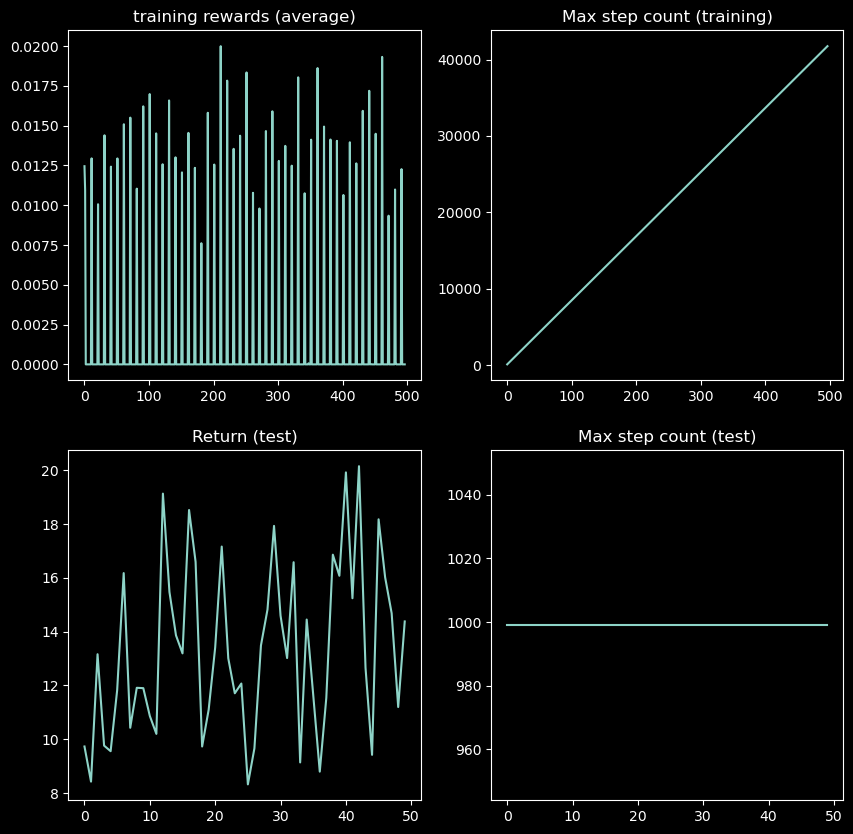

In [39]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()